In [1]:
!pip install segmentation_models_pytorch warmup_scheduler albumentations -q


In [2]:
import os
import sys
import random
from glob import glob
import warnings

import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

sys.path.append('/kaggle/working/notebook/experiment/2d')
from script.helper import *
from script.dataset import *
from script.metrics import *
from script.trainer import *
from script.model import *
from script.loss import *
from script.scheduler import *


## config

In [3]:
class ExtractLayers(A.ImageOnlyTransform):
    def __init__(self, in_channels, out_channels, is_train=True, always_apply=False, p=1):
        super(ExtractLayers, self).__init__(always_apply, p)
        self.is_train = is_train
        self.in_channels = in_channels
        self.out_channels = out_channels

    def apply(self, img, **params):
        if self.is_train:
            start = random.randint(0, self.in_channels-self.out_channels)
            end = start+self.out_channels
            img = img[:, :, start:end]
        else:
            img = img[:, :, 4:4+self.out_channels]
        return img


In [4]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'

    dataset_path = "/kaggle/working/dataset_train/"
    train_dataset_path = "/kaggle/working/dataset_train/nonflatten/25-37/"
    dataset_range = train_dataset_path.split("/")[-2]
    
    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============
    model_name = 'MAnet'
    backbone = 'se_resnext50_32x4d'
    in_chans = 6

    # ============== pred target =============
    target_size = 1

    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16  # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'

    epochs = 20  # 15

    warmup_factor = 10
    lr = 1e-4 / warmup_factor
    loss="bce_dice_loss"
    # ============== fold =============
    metric_direction = 'maximize'  # maximize, 'minimize'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3),
                        mask_fill_value=0, p=0.5),
        ExtractLayers(13, 6, is_train=True),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        ExtractLayers(13, 6, is_train=False),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True  # type: ignore

set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)


## Dataset

In [5]:
def preprocess(image, fragment_i, split_i):
    # topography = cv2.imread(f"{CFG.dataset_path}/topography_{fragment_i}_{split_i}.png",-1)
    # topography = topography.astype("uint16")*1057
    # pad0 = (CFG.tile_size - topography.shape[0] % CFG.tile_size)
    # pad1 = (CFG.tile_size - topography.shape[1] % CFG.tile_size)
    # topography = np.pad(topography, [(0, pad0), (0, pad1)], constant_values=0)
    # topography = np.expand_dims(topography, axis=2)
    # image=np.concatenate([image,topography], axis=2)
    return image



len(train_images) = 14624
train_images[0].shape = (224, 224, 13)
train_labels[0].shape = (224, 224, 1)
train_masks[0].shape = (224, 224, 1)

len(valid_images) = 4161
valid_images[0].shape = (224, 224, 13)
valid_labels[0].shape = (224, 224, 1)



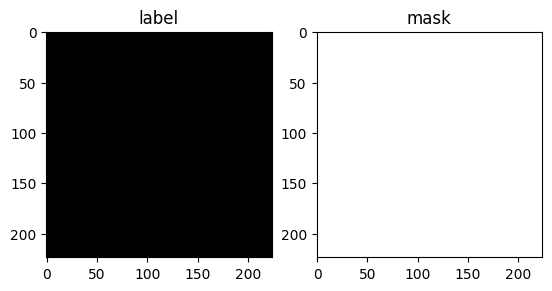

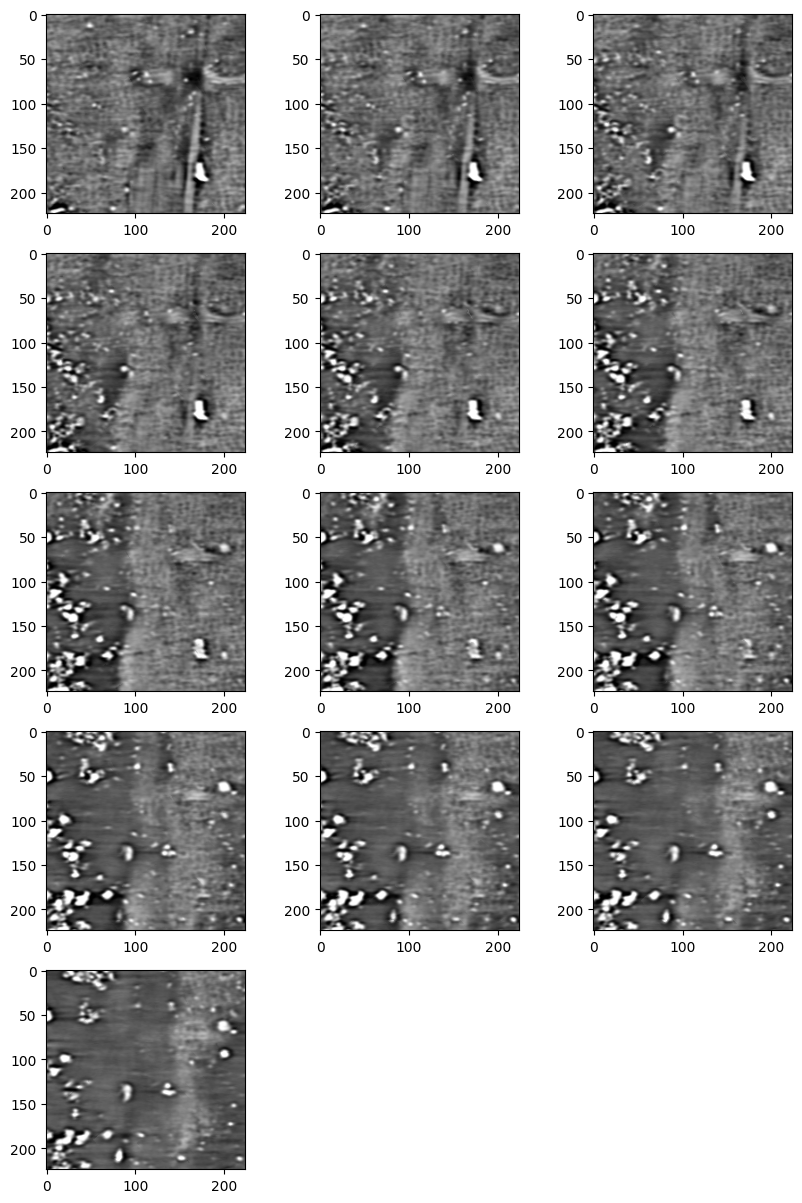

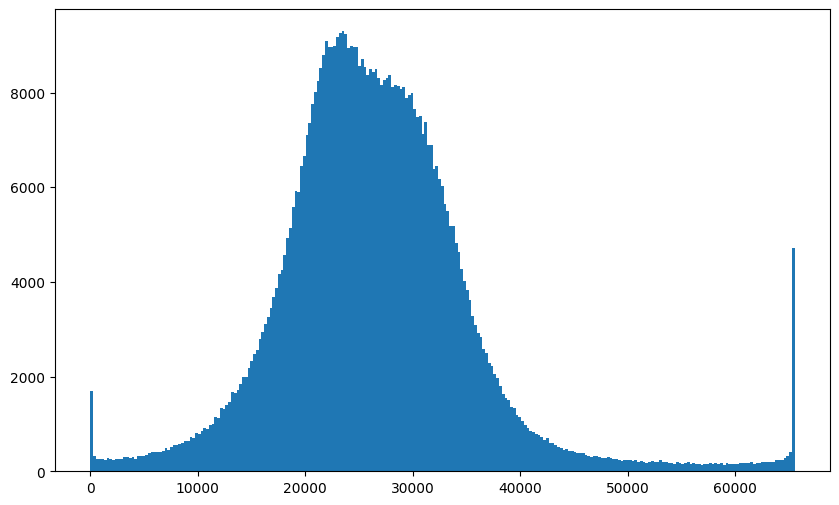

In [6]:
# confirmation

valid_fragment_i = 1
valid_split_i = 0

train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess)

print(f"""
{len(train_images) = }
{train_images[0].shape = }
{train_labels[0].shape = }
{train_masks[0].shape = }

{len(valid_images) = }
{valid_images[0].shape = }
{valid_labels[0].shape = }
""")

id = random.randint(0, len(train_labels))
visualize_train_images(id, train_images, train_labels, train_masks)


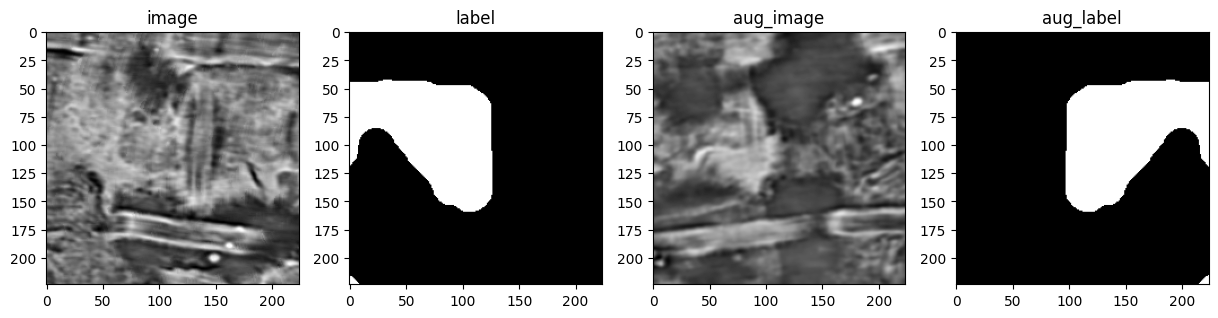

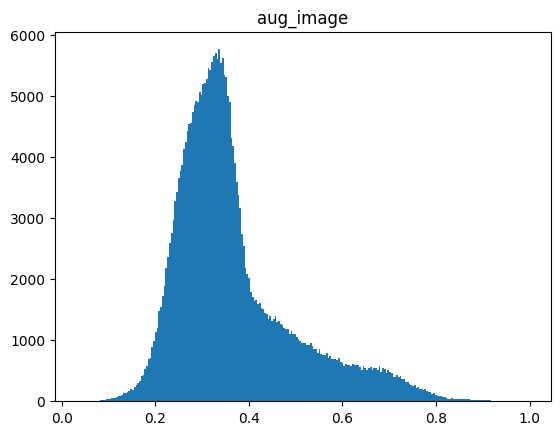

In [7]:
# confirmation
plot_dataset = CustomDataset(train_images, CFG, labels=train_labels)
visualize_dataset(plot_dataset, CFG)


## main

In [8]:
train_and_evaluate(preprocess, CFG)
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！' https://notify-api.line.me/api/notify

fold: 0
MAnet


100%|██████████| 131/131 [00:07<00:00, 18.24it/s]


fbeta: 0.3225
Epoch 1 - avg_train_loss: 1.3529  avg_val_loss: 1.1410  avgScore: 0.3225  time: 111s
Epoch 1 - Save Best Loss: 1.1410  Best Score: 0.3225 Model



100%|██████████| 131/131 [00:07<00:00, 18.71it/s]


fbeta: 0.4156
Epoch 2 - avg_train_loss: 1.1741  avg_val_loss: 0.9983  avgScore: 0.4156  time: 107s
Epoch 2 - Save Best Loss: 0.9983  Best Score: 0.4156 Model



100%|██████████| 131/131 [00:06<00:00, 18.84it/s]


fbeta: 0.4239
Epoch 3 - avg_train_loss: 1.0675  avg_val_loss: 0.8842  avgScore: 0.4239  time: 107s
Epoch 3 - Save Best Loss: 0.8842  Best Score: 0.4239 Model



100%|██████████| 131/131 [00:06<00:00, 19.03it/s]


fbeta: 0.4178
Epoch 4 - avg_train_loss: 0.9658  avg_val_loss: 0.9065  avgScore: 0.4178  time: 106s



100%|██████████| 131/131 [00:06<00:00, 19.01it/s]


fbeta: 0.4200
Epoch 5 - avg_train_loss: 0.9232  avg_val_loss: 0.8900  avgScore: 0.4200  time: 107s



100%|██████████| 131/131 [00:06<00:00, 18.81it/s]


fbeta: 0.3899
Epoch 6 - avg_train_loss: 0.9058  avg_val_loss: 0.9358  avgScore: 0.3899  time: 106s



100%|██████████| 131/131 [00:06<00:00, 18.85it/s]


fbeta: 0.3734
Epoch 7 - avg_train_loss: 0.8927  avg_val_loss: 0.9274  avgScore: 0.3734  time: 107s



100%|██████████| 131/131 [00:06<00:00, 18.72it/s]


fbeta: 0.4338
Epoch 8 - avg_train_loss: 0.8467  avg_val_loss: 0.9364  avgScore: 0.4338  time: 107s
Epoch 8 - Save Best Loss: 0.9364  Best Score: 0.4338 Model



100%|██████████| 131/131 [00:06<00:00, 18.77it/s]


fbeta: 0.3659
Epoch 9 - avg_train_loss: 0.8362  avg_val_loss: 0.9475  avgScore: 0.3659  time: 109s



100%|██████████| 131/131 [00:06<00:00, 18.73it/s]


fbeta: 0.3975
Epoch 10 - avg_train_loss: 0.8094  avg_val_loss: 0.9317  avgScore: 0.3975  time: 108s



100%|██████████| 131/131 [00:06<00:00, 18.79it/s]


fbeta: 0.4316
Epoch 11 - avg_train_loss: 0.8077  avg_val_loss: 0.9035  avgScore: 0.4316  time: 107s



100%|██████████| 131/131 [00:06<00:00, 18.80it/s]


fbeta: 0.4371
Epoch 12 - avg_train_loss: 0.7937  avg_val_loss: 0.9047  avgScore: 0.4371  time: 109s
Epoch 12 - Save Best Loss: 0.9047  Best Score: 0.4371 Model



100%|██████████| 131/131 [00:06<00:00, 18.87it/s]


fbeta: 0.4455
Epoch 13 - avg_train_loss: 0.7707  avg_val_loss: 0.9017  avgScore: 0.4455  time: 108s
Epoch 13 - Save Best Loss: 0.9017  Best Score: 0.4455 Model



100%|██████████| 131/131 [00:06<00:00, 19.12it/s]


fbeta: 0.0000
Epoch 14 - avg_train_loss: nan  avg_val_loss: nan  avgScore: 0.0000  time: 107s



100%|██████████| 131/131 [00:06<00:00, 19.29it/s]


fbeta: 0.0000
Epoch 15 - avg_train_loss: 0.7521  avg_val_loss: nan  avgScore: 0.0000  time: 106s



100%|██████████| 131/131 [00:06<00:00, 19.31it/s]


fbeta: 0.0000
Epoch 16 - avg_train_loss: 0.7461  avg_val_loss: nan  avgScore: 0.0000  time: 105s



100%|██████████| 131/131 [00:06<00:00, 19.37it/s]


fbeta: 0.0000
Epoch 17 - avg_train_loss: 0.7382  avg_val_loss: nan  avgScore: 0.0000  time: 105s



100%|██████████| 131/131 [00:06<00:00, 19.26it/s]


fbeta: 0.0000
Epoch 18 - avg_train_loss: 0.7266  avg_val_loss: nan  avgScore: 0.0000  time: 106s



100%|██████████| 131/131 [00:06<00:00, 19.29it/s]


fbeta: 0.0000
Epoch 19 - avg_train_loss: 0.7182  avg_val_loss: nan  avgScore: 0.0000  time: 106s



100%|██████████| 131/131 [00:06<00:00, 19.32it/s]


fbeta: 0.0000
Epoch 20 - avg_train_loss: 0.7069  avg_val_loss: nan  avgScore: 0.0000  time: 105s

fold: 1
MAnet


100%|██████████| 120/120 [00:06<00:00, 18.64it/s]


fbeta: 0.3095
Epoch 1 - avg_train_loss: 1.1468  avg_val_loss: 0.7457  avgScore: 0.3095  time: 109s
Epoch 1 - Save Best Loss: 0.7457  Best Score: 0.3095 Model



100%|██████████| 120/120 [00:06<00:00, 18.71it/s]


fbeta: 0.4366
Epoch 2 - avg_train_loss: 1.0516  avg_val_loss: 0.6766  avgScore: 0.4366  time: 109s
Epoch 2 - Save Best Loss: 0.6766  Best Score: 0.4366 Model



100%|██████████| 120/120 [00:06<00:00, 18.73it/s]


fbeta: 0.3109
Epoch 3 - avg_train_loss: 1.0310  avg_val_loss: 0.6973  avgScore: 0.3109  time: 108s



100%|██████████| 120/120 [00:06<00:00, 18.88it/s]


fbeta: 0.4992
Epoch 4 - avg_train_loss: 0.9676  avg_val_loss: 0.6217  avgScore: 0.4992  time: 108s
Epoch 4 - Save Best Loss: 0.6217  Best Score: 0.4992 Model



100%|██████████| 120/120 [00:06<00:00, 18.83it/s]


fbeta: 0.4822
Epoch 5 - avg_train_loss: 0.9101  avg_val_loss: 0.6128  avgScore: 0.4822  time: 108s



100%|██████████| 120/120 [00:06<00:00, 18.76it/s]


fbeta: 0.4905
Epoch 6 - avg_train_loss: 0.8672  avg_val_loss: 0.6002  avgScore: 0.4905  time: 108s



100%|██████████| 120/120 [00:06<00:00, 18.73it/s]


fbeta: 0.0000
Epoch 7 - avg_train_loss: nan  avg_val_loss: nan  avgScore: 0.0000  time: 107s



100%|██████████| 120/120 [00:06<00:00, 18.91it/s]


fbeta: 0.0000
Epoch 8 - avg_train_loss: nan  avg_val_loss: nan  avgScore: 0.0000  time: 95s



100%|██████████| 120/120 [00:06<00:00, 18.24it/s]


fbeta: 0.0000
Epoch 9 - avg_train_loss: nan  avg_val_loss: nan  avgScore: 0.0000  time: 94s



 12%|█▏        | 113/935 [00:10<01:18, 10.42it/s]


KeyboardInterrupt: 

: 

In [ ]:
gt_area_list, dice_list, valid_label_gt_list, label_pred_list = inference_evaluation(CFG)


fbeta: 0.5607
fbeta: 0.6006
fbeta: 0.5938
fbeta: 0.6524
fbeta: 0.5402


In [ ]:
print(f"{dice_evaluation(gt_area_list, dice_list):.4f}")


0.5908


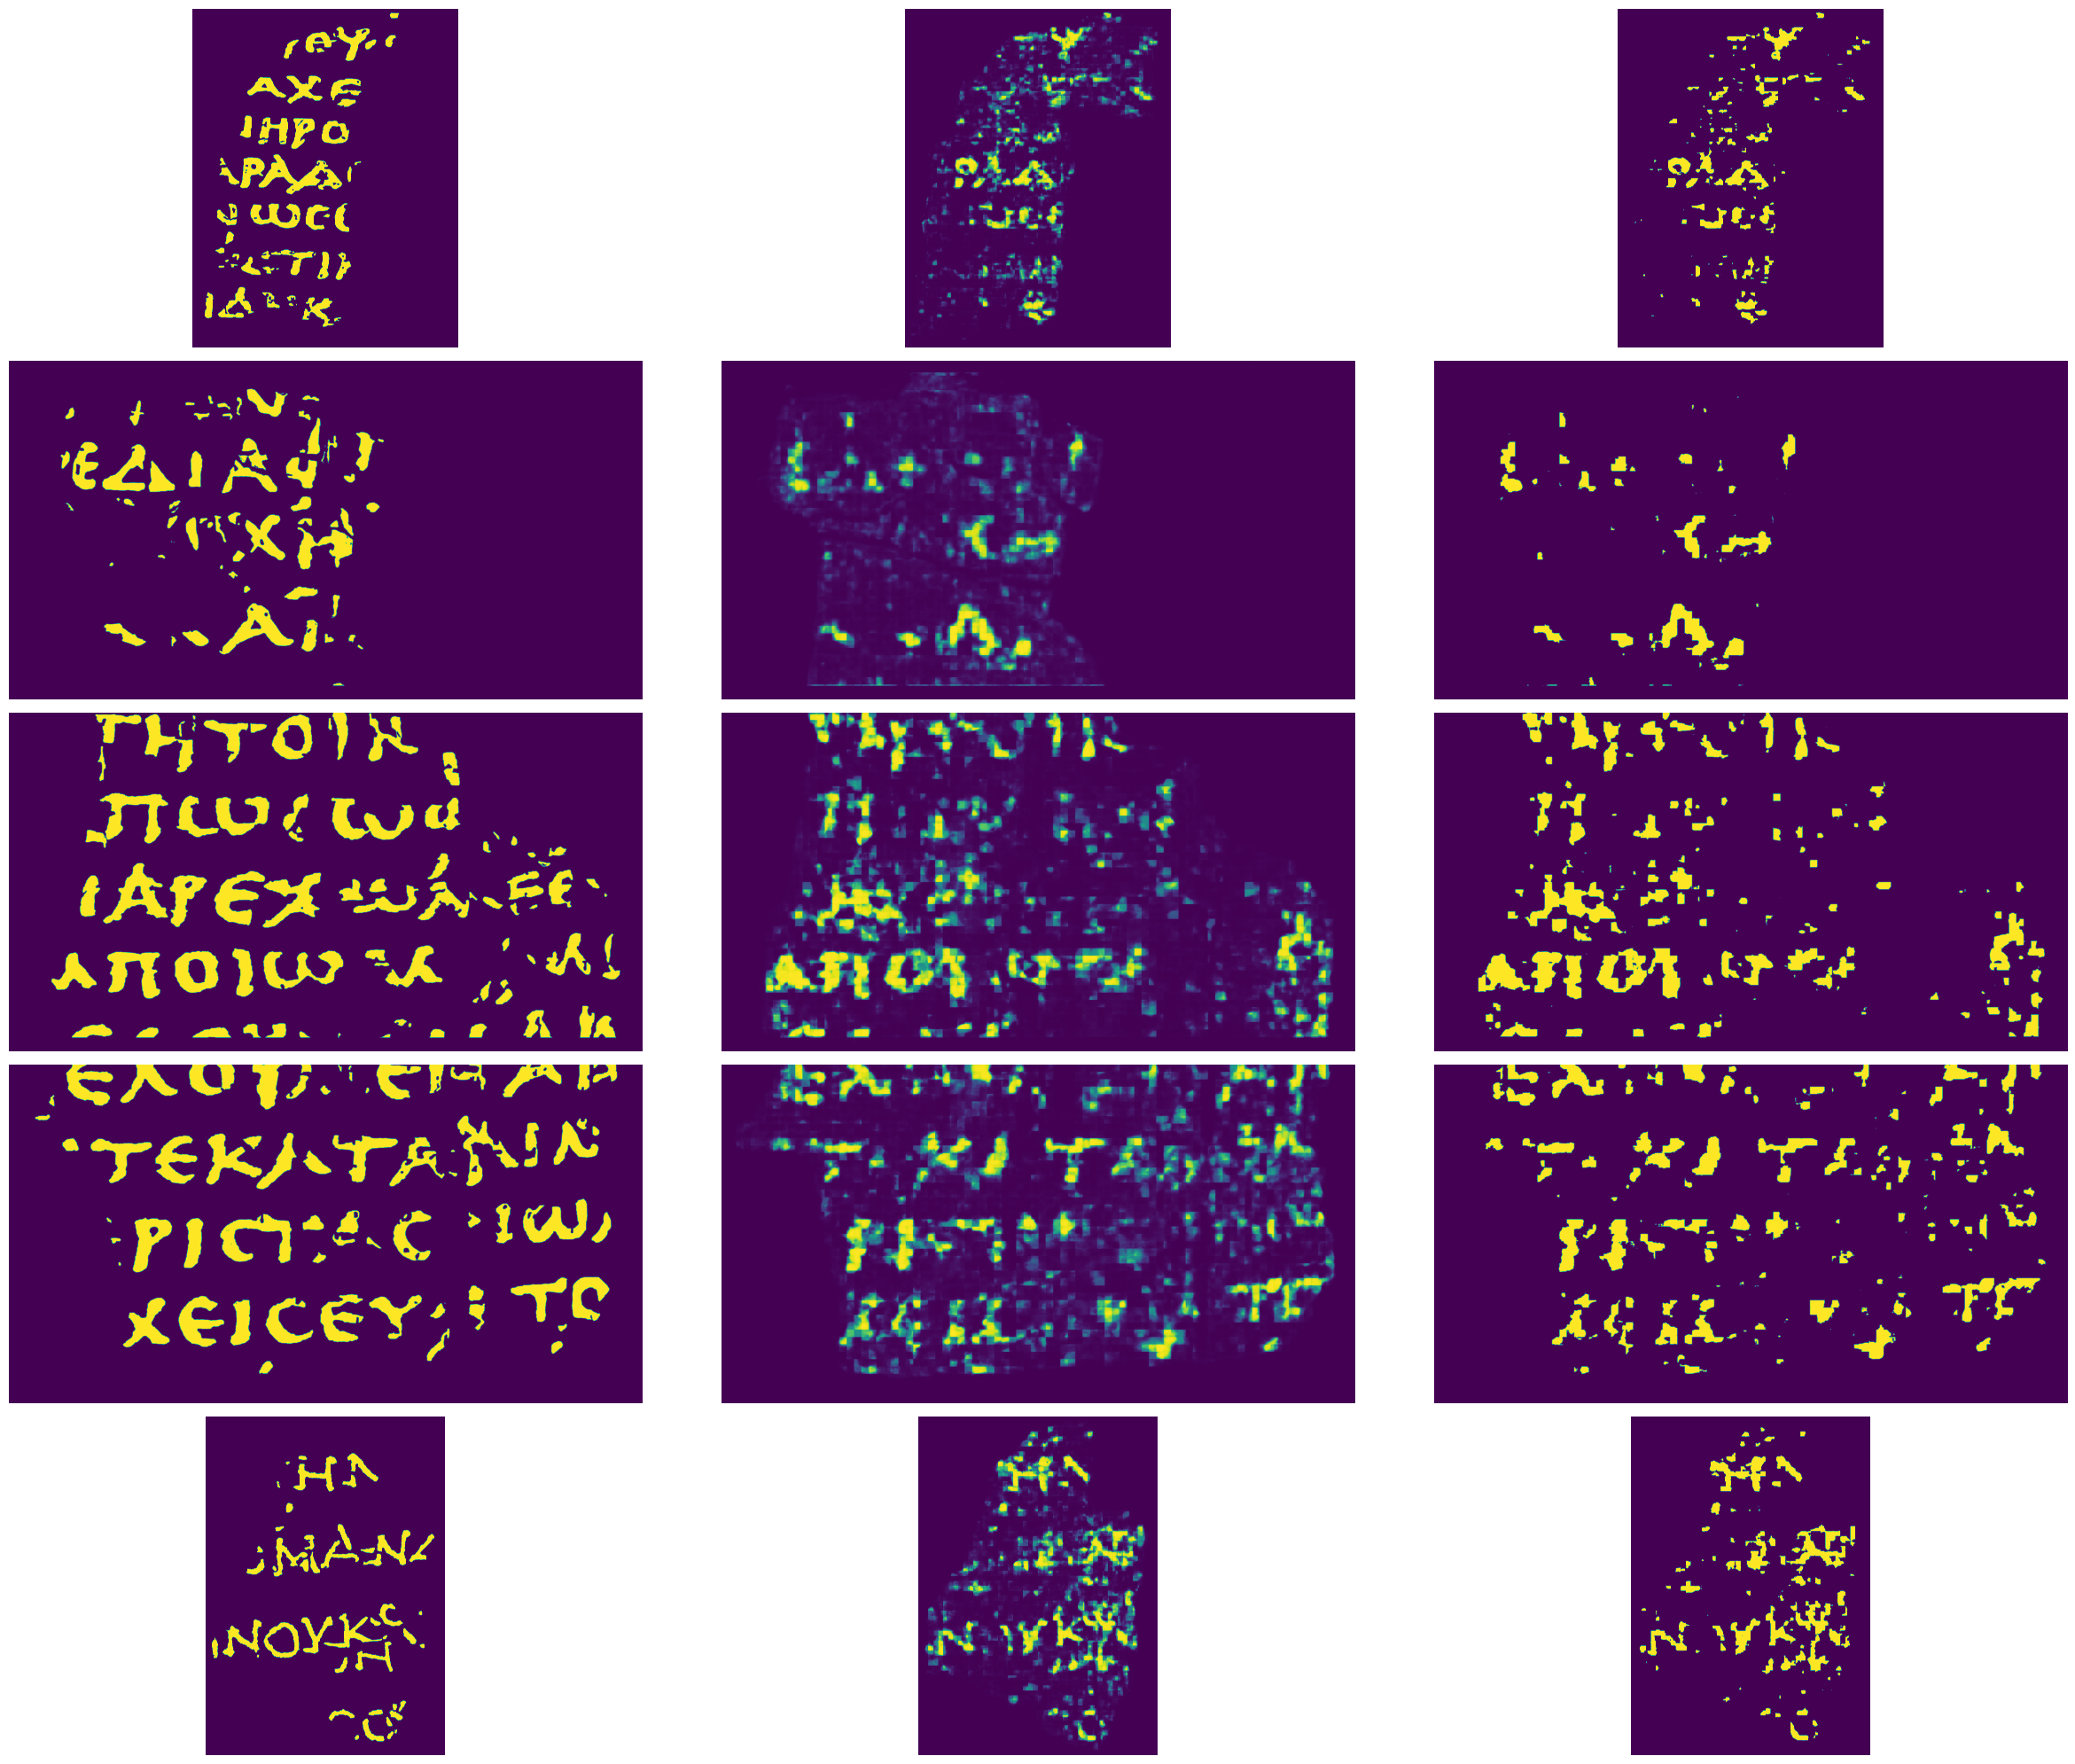

In [ ]:
plot_inference(valid_label_gt_list, label_pred_list, CFG)